## This is a FSI problem of 2D cylinder RotatingCylinder in uniform flow

Considering the fictitious fluid inside the cylinder due to immersed boundary method, also considering buoyancy, body density set in the code should be set to a different value. For example if you want to set $\rho = 3$, the density set in the code should be $\rho-1=2$. If you want to set $\rho = 2$, the density set in the code should be $\rho-1=1$.

To keep consistency between *Dyn3d* and *ViscousFlow*, the cylinder is setup in z-x coordinates, so gravity should also be set in z direction

In [ ]:
using Pkg
Pkg.activate("..")
using FSI

In [2]:
using Revise
using BSON: @save, @load

using Plots
pyplot()
clibrary(:colorbrewer)
default(grid = false)

In [3]:
filename = "RotatingCylinder";

## <span style="color:blue"> Set up rigid body with Dyn3d

#### Include any joint-body setup script from Dyn3d

In [4]:
ndim = 2
# numerical params
tf = 1.0
dt = 1e-3
scheme = "Liska"
st = 3
tol = 1e-4
num_params = NumParams(tf, dt, scheme, st, tol)
# gravity
gravity = [0., 0.0, 0.0]

# set up system config info
config_system = ConfigSystem(ndim, gravity, num_params)

# set up bodys
function circle(z₀::Vector{Float64}, r::Float64, n::Int)
    # z₀ for circle center location, r for radius and n for # of points on circle
    verts = zeros(n,2)
    for i = 1:n
        verts[i,:] = [r*cos(2π/(n)*(i-1)) + z₀[1], r*sin(2π/(n)*(i-1)) + z₀[2]]
    end
    return verts
end

nbody = 1
nverts = 157
verts = circle([0.,0.], 0.5, nverts)
config_body = ConfigBody(nbody, nverts, verts, 1.0)
config_bodys = fill(config_body, nbody)

# set up joints
njoint = nbody
config_joints = Vector{ConfigJoint}(undef,njoint)

# set the first passive joint with no stiff and damp
dofₐ = Dof(2, "active", 0., 0., Motions("velocity",[0.0,1.0]))
config_joints[1] = ConfigJoint(njoint, "custom_revolute_in_y",
    [0.0,0.0,0.0,1.5,0.0,1.5], zeros(Float64,6), 0, [dofₐ], [0.0])

 joint type = custom_revolute_in_y
 joint position in parent body coord = [0.0, 0.0, 0.0, 1.5, 0.0, 1.5]
 joint position in child body coord = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
 joint unconstrained dof = 2, under active velocity motion
 initial unconstrained dof position = [0.0]


#### Build joint-body chain

In [5]:
bs, js, bsys = BuildChain(config_bodys, config_joints, config_system)
bd = BodyDyn(bs, js, bsys)

This is a 1 body-joint system, system is fixed in space

#### Initialize rigid body system state to complete body-joint information

In [6]:
bd, soln₀ = InitSystem!(bd);

#### Initialize u and λ container

In [7]:
qJ = soln₀.qJ
v = soln₀.v
λ_dim = bd.sys.ncdof_HERK
λ = zeros(Float64,λ_dim);

#### Get body verts for plotting

In [8]:
@get bd (bs, js, sys)
bs, js, sys = UpdatePosition!(bs, js, sys, soln₀.qJ)
vs₀ = VertsHistory(sys.nbody, bs);

#### Plot body only

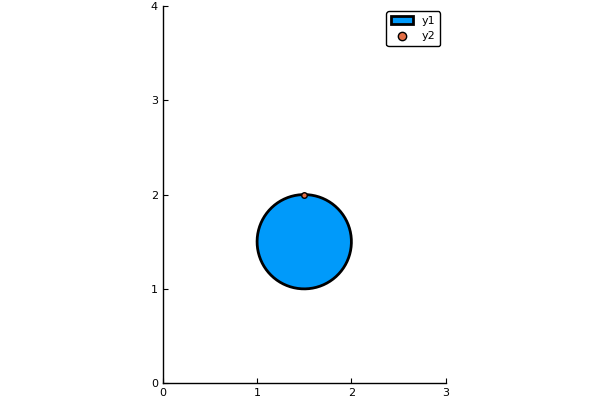

In [9]:
p = plot()
for i = 1:sys.nbody
    plot!(p,vs₀[i,[1:nverts;1],1], vs₀[i,[1:nverts;1],3],linewidth=2,linecolor="black",fill=true)
    plot!(p,[vs₀[i,1,1]], [vs₀[i,1,3]],seriestype=:scatter)
end
plot!(xlims=(0,3), ylims=(0,4),ratio=1)

## <span style="color:blue"> Set up fluid with Whirl </span>

#### Set the flow parameters

In [10]:
Re = 200 # Reynolds number
U = 1.0 # Free stream velocity
U∞ = (U,0.0)

(1.0, 0.0)

#### Set the domain grid

In [11]:
nx = 202; ny = 152;
Ly = 3.0;
Δx = Ly/(ny-2);

Δt = min(0.5*Δx,0.5*Δx^2*Re)

w₀ = Nodes(Dual,(nx,ny))
xg, yg = coordinates(w₀,dx=Δx)

(-0.01:0.02:4.01, -0.01:0.02:3.0100000000000002)

#### Set up fluid initial conditions

In [12]:
w₀ .= 0.0;
w = deepcopy(w₀);

## <span style="color:blue"> Create fluid-body interface </span>

#### Body in fluid plane

In [13]:
plane = [1,3];

#### Genrate body grid points and get linear velocity on them

In [14]:
bgs = GenerateBodyGrid(bd; np=DetermineNP(nbody, Δx));

#### Get body points initial coordinates for fluids

In [15]:
bgs = AcquireBodyGridKinematics(bd,bgs);

#### Set up body grid points and force container in fluid

In [16]:
X̃ = BodyGridToVectorData(bgs,"coord";plane=plane)
f = VectorData(X̃);

#### Create fluidstruct structure

In [17]:
tf = 500Δt
T = Δt:Δt:tf
fsys = FluidStruct((nx,ny),Re,Δx,Δt,U∞ = U∞, X̃ = X̃, rk=RK31)
N = length(X̃)÷2
Δt

0.01

## <span style="color:blue"> Create ifherk object </span>

In [18]:
@time ifherk_coupled = IFHERK_coupled(fsys.Δt,bd,bgs,(w₀,qJ,v,f,λ),
                ((t,u) -> Systems.plan_intfact(t,u,fsys), B₁ᵀ, B₂),
                (M⁻¹, G₁ᵀ, G₂, UpP, UpV),
                ((bd,bgs,f) -> T₁ᵀ(bd,bgs,f,fsys.Δx;plane=plane),
                 (bd,bgs,u) -> T₂(bd,bgs,u;plane=plane),
                 (bd,bgs) -> getX̃(bd,bgs;plane=plane)),
                ((w,t) -> FSI.r₁(w,t,fsys), F, w -> U_inf(w,fsys), gti),
                fsys, tol=1e-3,rk=TimeMarching.RK31)

 12.715735 seconds (60.14 M allocations: 3.676 GiB, 6.17% gc time)


Stage-3+ IF-HERK integrator with
   Time step size 0.01


In [19]:
fx = Float64[]
fy = Float64[]
t = 0.0
thist = []
whist = []
bdhist = BodyDyn[];

## <span style="color:blue"> TimeMarching! </span>

In [ ]:
@time for ti in T
    
    @time global t, (w, f), (qJ, v, λ), bd = ifherk_coupled(t, w, qJ, v, bd,fsys)
    
    push!(thist,t-Δt)
    push!(fx,sum(f.u)*Δx^2)
    push!(fy,sum(f.v)*Δx^2)
    push!(whist,deepcopy(w))
    push!(bdhist,deepcopy(bd))
    println("next time unit is $(round(t,digits=3))")
    
    if mod(round(Int,ti/Δt),200) == 1  
        @save filename*".bson" bd bdhist xg yg whist thist fx fy Δt w qJ v
        println("data saved at time ", ti)
    end
end

In [35]:
@time for ti in 501Δt:Δt:1500Δt
    
    @time global t, (w, f), (qJ, v, λ), bd = ifherk_coupled(t, w, qJ, v, bd,fsys)
    
    push!(thist,t-Δt)
    push!(fx,sum(f.u)*Δx^2)
    push!(fy,sum(f.v)*Δx^2)
    push!(whist,deepcopy(w))
    push!(bdhist,deepcopy(bd))
    println("next time unit is $(round(t,digits=3))")
    
    if mod(round(Int,ti/Δt),200) == 1  
        @save filename*".bson" bd bdhist xg yg whist thist fx fy Δt w qJ v
        println("data saved at time ", ti)
    end
end

  8.937720 seconds (46.60 M allocations: 3.043 GiB, 5.58% gc time)
next time unit is 5.01
  7.407986 seconds (43.28 M allocations: 2.882 GiB, 5.99% gc time)
next time unit is 5.02
  7.963311 seconds (43.28 M allocations: 2.882 GiB, 5.89% gc time)
next time unit is 5.03
  7.879537 seconds (43.28 M allocations: 2.882 GiB, 5.78% gc time)
next time unit is 5.04
  7.670287 seconds (43.28 M allocations: 2.882 GiB, 7.00% gc time)
next time unit is 5.05
  7.596241 seconds (43.28 M allocations: 2.882 GiB, 5.43% gc time)
next time unit is 5.06
  7.747848 seconds (43.28 M allocations: 2.882 GiB, 5.48% gc time)
next time unit is 5.07
  7.737121 seconds (43.28 M allocations: 2.882 GiB, 5.47% gc time)
next time unit is 5.08
  7.583722 seconds (43.28 M allocations: 2.882 GiB, 5.61% gc time)
next time unit is 5.09
  7.697225 seconds (43.28 M allocations: 2.882 GiB, 6.96% gc time)
next time unit is 5.1
  7.837494 seconds (43.28 M allocations: 2.882 GiB, 5.50% gc time)
next time unit is 5.11
  7.593301 

  7.064560 seconds (43.28 M allocations: 2.882 GiB, 5.53% gc time)
next time unit is 5.93
  7.063503 seconds (43.28 M allocations: 2.882 GiB, 5.61% gc time)
next time unit is 5.94
  7.187131 seconds (43.28 M allocations: 2.882 GiB, 5.54% gc time)
next time unit is 5.95
  7.372141 seconds (43.28 M allocations: 2.882 GiB, 5.56% gc time)
next time unit is 5.96
  7.325897 seconds (43.28 M allocations: 2.882 GiB, 6.89% gc time)
next time unit is 5.97
  7.113516 seconds (43.28 M allocations: 2.882 GiB, 5.51% gc time)
next time unit is 5.98
  7.131134 seconds (43.28 M allocations: 2.882 GiB, 5.48% gc time)
next time unit is 5.99
  7.172834 seconds (43.28 M allocations: 2.882 GiB, 5.60% gc time)
next time unit is 6.0
  7.199359 seconds (43.28 M allocations: 2.882 GiB, 5.55% gc time)
next time unit is 6.01
data saved at time 6.01
  7.548490 seconds (43.28 M allocations: 2.882 GiB, 7.97% gc time)
next time unit is 6.02
  7.317986 seconds (43.28 M allocations: 2.882 GiB, 6.18% gc time)
next time 

  7.178507 seconds (43.28 M allocations: 2.882 GiB, 5.59% gc time)
next time unit is 6.84
  7.202904 seconds (43.28 M allocations: 2.882 GiB, 5.67% gc time)
next time unit is 6.85
  7.326686 seconds (43.28 M allocations: 2.882 GiB, 5.75% gc time)
next time unit is 6.86
  7.260874 seconds (43.28 M allocations: 2.882 GiB, 5.80% gc time)
next time unit is 6.87
  7.140845 seconds (43.28 M allocations: 2.882 GiB, 6.93% gc time)
next time unit is 6.88
  7.045172 seconds (43.28 M allocations: 2.882 GiB, 5.60% gc time)
next time unit is 6.89
  7.111143 seconds (43.28 M allocations: 2.882 GiB, 5.54% gc time)
next time unit is 6.9
  7.075084 seconds (43.28 M allocations: 2.882 GiB, 5.62% gc time)
next time unit is 6.91
  7.171719 seconds (43.28 M allocations: 2.882 GiB, 5.55% gc time)
next time unit is 6.92
  7.337846 seconds (43.28 M allocations: 2.882 GiB, 5.68% gc time)
next time unit is 6.93
  7.257040 seconds (43.28 M allocations: 2.882 GiB, 6.90% gc time)
next time unit is 6.94
  7.166415 

  7.059135 seconds (43.28 M allocations: 2.882 GiB, 5.55% gc time)
next time unit is 7.76
  7.106402 seconds (43.28 M allocations: 2.882 GiB, 5.54% gc time)
next time unit is 7.77
  7.035580 seconds (43.28 M allocations: 2.882 GiB, 5.67% gc time)
next time unit is 7.78
  7.161790 seconds (43.28 M allocations: 2.882 GiB, 5.56% gc time)
next time unit is 7.79
  7.035299 seconds (43.28 M allocations: 2.882 GiB, 5.68% gc time)
next time unit is 7.8
  7.122405 seconds (43.28 M allocations: 2.882 GiB, 6.90% gc time)
next time unit is 7.81
  7.094847 seconds (43.28 M allocations: 2.882 GiB, 5.53% gc time)
next time unit is 7.82
  6.996313 seconds (43.28 M allocations: 2.882 GiB, 5.58% gc time)
next time unit is 7.83
  7.068717 seconds (43.28 M allocations: 2.882 GiB, 5.63% gc time)
next time unit is 7.84
  7.063312 seconds (43.28 M allocations: 2.882 GiB, 5.64% gc time)
next time unit is 7.85
  7.213303 seconds (43.28 M allocations: 2.882 GiB, 5.69% gc time)
next time unit is 7.86
  7.198944 

  7.117941 seconds (43.28 M allocations: 2.882 GiB, 5.54% gc time)
next time unit is 8.67
  7.011658 seconds (43.28 M allocations: 2.882 GiB, 5.64% gc time)
next time unit is 8.68
  7.057056 seconds (43.28 M allocations: 2.882 GiB, 5.68% gc time)
next time unit is 8.69
  7.101573 seconds (43.28 M allocations: 2.882 GiB, 5.61% gc time)
next time unit is 8.7
  7.168256 seconds (43.28 M allocations: 2.882 GiB, 6.93% gc time)
next time unit is 8.71
  7.047402 seconds (43.28 M allocations: 2.882 GiB, 5.52% gc time)
next time unit is 8.72
  7.032322 seconds (43.28 M allocations: 2.882 GiB, 5.62% gc time)
next time unit is 8.73
  7.114875 seconds (43.28 M allocations: 2.882 GiB, 5.58% gc time)
next time unit is 8.74
  7.032266 seconds (43.28 M allocations: 2.882 GiB, 5.71% gc time)
next time unit is 8.75
  7.030297 seconds (43.28 M allocations: 2.882 GiB, 5.67% gc time)
next time unit is 8.76
  7.167478 seconds (43.28 M allocations: 2.882 GiB, 6.81% gc time)
next time unit is 8.77
  6.978958 

  7.084285 seconds (43.28 M allocations: 2.882 GiB, 5.55% gc time)
next time unit is 9.59
  6.981885 seconds (43.28 M allocations: 2.882 GiB, 5.64% gc time)
next time unit is 9.6
  7.009396 seconds (43.28 M allocations: 2.882 GiB, 5.62% gc time)
next time unit is 9.61
  7.038157 seconds (43.28 M allocations: 2.882 GiB, 5.69% gc time)
next time unit is 9.62
  7.056586 seconds (43.28 M allocations: 2.882 GiB, 5.64% gc time)
next time unit is 9.63
  7.173450 seconds (43.28 M allocations: 2.882 GiB, 6.79% gc time)
next time unit is 9.64
  7.085613 seconds (43.28 M allocations: 2.882 GiB, 5.52% gc time)
next time unit is 9.65
  7.080269 seconds (43.28 M allocations: 2.882 GiB, 5.60% gc time)
next time unit is 9.66
  7.056612 seconds (43.28 M allocations: 2.882 GiB, 5.58% gc time)
next time unit is 9.67
  7.083363 seconds (43.28 M allocations: 2.882 GiB, 5.66% gc time)
next time unit is 9.68
  7.030239 seconds (43.28 M allocations: 2.882 GiB, 5.68% gc time)
next time unit is 9.69
  7.108718 

  7.082661 seconds (43.28 M allocations: 2.882 GiB, 5.55% gc time)
next time unit is 10.5
  7.054470 seconds (43.28 M allocations: 2.882 GiB, 5.61% gc time)
next time unit is 10.51
  7.023907 seconds (43.28 M allocations: 2.882 GiB, 5.68% gc time)
next time unit is 10.52
  7.024871 seconds (43.28 M allocations: 2.882 GiB, 5.63% gc time)
next time unit is 10.53
  7.103295 seconds (43.28 M allocations: 2.882 GiB, 6.95% gc time)
next time unit is 10.54
  7.125746 seconds (43.28 M allocations: 2.882 GiB, 5.54% gc time)
next time unit is 10.55
  7.097631 seconds (43.28 M allocations: 2.882 GiB, 5.57% gc time)
next time unit is 10.56
  7.124771 seconds (43.28 M allocations: 2.882 GiB, 5.53% gc time)
next time unit is 10.57
  7.021484 seconds (43.28 M allocations: 2.882 GiB, 5.73% gc time)
next time unit is 10.58
  7.155685 seconds (43.28 M allocations: 2.882 GiB, 6.85% gc time)
next time unit is 10.59
  7.100976 seconds (43.28 M allocations: 2.882 GiB, 5.54% gc time)
next time unit is 10.6
 

  7.122998 seconds (43.28 M allocations: 2.882 GiB, 6.88% gc time)
next time unit is 11.41
  7.080465 seconds (43.28 M allocations: 2.882 GiB, 5.53% gc time)
next time unit is 11.42
  7.050814 seconds (43.28 M allocations: 2.882 GiB, 5.61% gc time)
next time unit is 11.43
  7.047580 seconds (43.28 M allocations: 2.882 GiB, 5.58% gc time)
next time unit is 11.44
  6.990766 seconds (43.28 M allocations: 2.882 GiB, 5.73% gc time)
next time unit is 11.45
  7.119189 seconds (43.28 M allocations: 2.882 GiB, 6.91% gc time)
next time unit is 11.46
  7.053497 seconds (43.28 M allocations: 2.882 GiB, 5.57% gc time)
next time unit is 11.47
  7.042619 seconds (43.28 M allocations: 2.882 GiB, 5.53% gc time)
next time unit is 11.48
  7.003219 seconds (43.28 M allocations: 2.882 GiB, 5.64% gc time)
next time unit is 11.49
  7.097444 seconds (43.28 M allocations: 2.882 GiB, 5.59% gc time)
next time unit is 11.5
  7.028283 seconds (43.28 M allocations: 2.882 GiB, 5.65% gc time)
next time unit is 11.51


  7.256825 seconds (43.28 M allocations: 2.882 GiB, 5.50% gc time)
next time unit is 12.31
  7.065391 seconds (43.28 M allocations: 2.882 GiB, 5.69% gc time)
next time unit is 12.32
  6.997960 seconds (43.28 M allocations: 2.882 GiB, 5.73% gc time)
next time unit is 12.33
  7.086440 seconds (43.28 M allocations: 2.882 GiB, 5.73% gc time)
next time unit is 12.34
  7.233331 seconds (43.28 M allocations: 2.882 GiB, 5.71% gc time)
next time unit is 12.35
  7.418120 seconds (43.28 M allocations: 2.882 GiB, 7.04% gc time)
next time unit is 12.36
  7.361489 seconds (43.28 M allocations: 2.882 GiB, 5.58% gc time)
next time unit is 12.37
  7.366154 seconds (43.28 M allocations: 2.882 GiB, 5.58% gc time)
next time unit is 12.38
  7.624058 seconds (43.28 M allocations: 2.882 GiB, 5.47% gc time)
next time unit is 12.39
  7.339652 seconds (43.28 M allocations: 2.882 GiB, 5.64% gc time)
next time unit is 12.4
  7.332321 seconds (43.28 M allocations: 2.882 GiB, 5.72% gc time)
next time unit is 12.41


  7.323914 seconds (43.28 M allocations: 2.882 GiB, 5.70% gc time)
next time unit is 13.22
  7.437323 seconds (43.28 M allocations: 2.882 GiB, 6.93% gc time)
next time unit is 13.23
  7.208344 seconds (43.28 M allocations: 2.882 GiB, 5.67% gc time)
next time unit is 13.24
  7.312059 seconds (43.28 M allocations: 2.882 GiB, 5.53% gc time)
next time unit is 13.25
  7.326372 seconds (43.28 M allocations: 2.882 GiB, 5.61% gc time)
next time unit is 13.26
  7.393413 seconds (43.28 M allocations: 2.882 GiB, 5.60% gc time)
next time unit is 13.27
  7.335098 seconds (43.28 M allocations: 2.882 GiB, 5.74% gc time)
next time unit is 13.28
  7.397015 seconds (43.28 M allocations: 2.882 GiB, 6.97% gc time)
next time unit is 13.29
  7.230657 seconds (43.28 M allocations: 2.882 GiB, 5.67% gc time)
next time unit is 13.3
  7.216860 seconds (43.28 M allocations: 2.882 GiB, 5.68% gc time)
next time unit is 13.31
  7.275488 seconds (43.28 M allocations: 2.882 GiB, 5.68% gc time)
next time unit is 13.32


  7.425860 seconds (43.28 M allocations: 2.882 GiB, 5.60% gc time)
next time unit is 14.12
  7.533651 seconds (43.28 M allocations: 2.882 GiB, 6.94% gc time)
next time unit is 14.13
  7.493648 seconds (43.28 M allocations: 2.882 GiB, 5.57% gc time)
next time unit is 14.14
  7.481738 seconds (43.28 M allocations: 2.882 GiB, 5.52% gc time)
next time unit is 14.15
  7.395168 seconds (43.28 M allocations: 2.882 GiB, 5.57% gc time)
next time unit is 14.16
  7.329044 seconds (43.28 M allocations: 2.882 GiB, 5.65% gc time)
next time unit is 14.17
  7.299872 seconds (43.28 M allocations: 2.882 GiB, 5.76% gc time)
next time unit is 14.18
  7.462664 seconds (43.28 M allocations: 2.882 GiB, 6.90% gc time)
next time unit is 14.19
  7.222321 seconds (43.28 M allocations: 2.882 GiB, 5.63% gc time)
next time unit is 14.2
  7.216634 seconds (43.28 M allocations: 2.882 GiB, 5.60% gc time)
next time unit is 14.21
  7.234236 seconds (43.28 M allocations: 2.882 GiB, 5.68% gc time)
next time unit is 14.22


## <span style="color:blue"> Plot </span>

#### Set contour levels and fps

In [36]:
contour_levels = range(0.5*minimum(w.data),stop=0.5*maximum(w.data),length=40)
sample_freq = 2
fps = 25;

#### Get body verts history

In [37]:
vshist = []
for i = 1:length(bdhist)
    push!(vshist, VertsHistory(bdhist[i].sys.nbody, bdhist[i].bs))
end
fb = [1:nverts;1];

#### Plot first and last time field

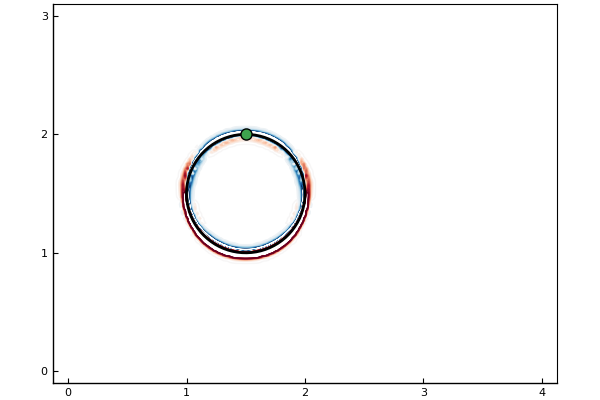

In [38]:
p = plot(xg,yg,whist[1],levels=contour_levels,color=:RdBu_r,clims=(-0.25,0.25))
for i = 1:bd.sys.nbody
    plot!(p,vshist[1][i,fb,1], vshist[1][i,fb,plane[2]],linewidth=2,linecolor="black", fill=false)
    plot!(p,[vshist[1][i,1,1]], [vshist[1][i,1,plane[2]]],seriestype=:scatter,markersize=8)
end
p

In [39]:
# kk = 50
# p = plot(xg,yg,whist[kk],levels=contour_levels,color=:RdBu_r,clims=(-0.2,0.2))
# for i = 1:bd.sys.nbody
# #     plot!(p,vshist[kk][i,fb,1], vshist[kk][i,fb,plane[2]],linewidth=2,linecolor="black", fill=true)
#     plot!(p,vshist[kk][i,fb,1], vshist[kk][i,fb,plane[2]],linewidth=2,linecolor="black")
#     plot!(p,[vshist[kk][i,1,1]], [vshist[kk][i,1,plane[2]]],seriestype=:scatter,markersize=8)
    
# end
# # savefig(p,"plate.eps")
# p

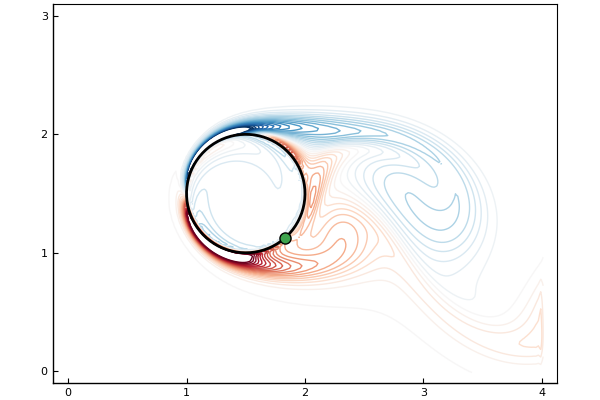

In [40]:
p = plot(xg,yg,whist[end],levels=contour_levels,color=:RdBu_r,clims=(-0.25,0.25))
for i = 1:bd.sys.nbody
    plot!(p,vshist[end][i,fb,1], vshist[end][i,fb,plane[2]],linewidth=2,linecolor="black", fill=false)
    plot!(p,[vshist[end][i,1,1]], [vshist[end][i,1,plane[2]]],seriestype=:scatter,markersize=8)
end
p

#### Make gif

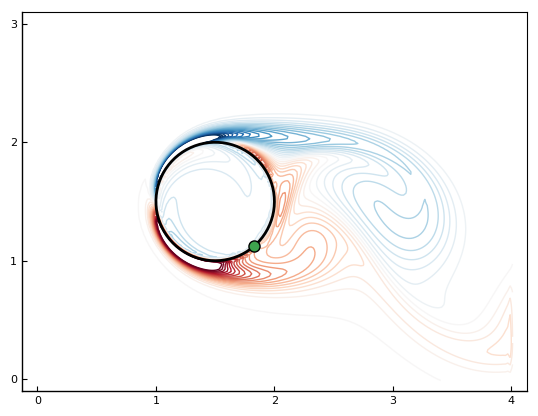

┌ Info: Saved animation to 
│   fn = /mnt/g/Research/FSI.jl/examples/RotatingCylinder-uniform-flow.gif
└ @ Plots /home/fs/.julia/packages/Plots/oiirH/src/animation.jl:90


Plots.AnimatedGif("/mnt/g/Research/FSI.jl/examples/RotatingCylinder-uniform-flow.gif")

In [41]:
anim = @animate for j = 1:sample_freq:length(whist)
    plot(xg,yg,whist[j],levels=contour_levels,color=:RdBu_r,clims=(-0.25,0.25))
    for i = 1:sys.nbody
        plot!(vshist[j][i,fb,1], vshist[j][i,fb,plane[2]],linewidth=2,linecolor="black",fill=false)
        plot!([vshist[j][i,1,1]], [vshist[j][i,1,plane[2]]],seriestype=:scatter,markersize=8)
    end
end

gif(anim, filename*".gif", fps = fps)

#### Get cylinder position and velocity in time

In [42]:
vhist = [0.0]
phist = [0.0]

for i in 1:length(bdhist)
    push!(vhist,bdhist[i].js[1].vJ[2])
    push!(phist,bdhist[i].js[1].qJ[2])    
end

#### Plot cylinder angular position, velocity, acceleration

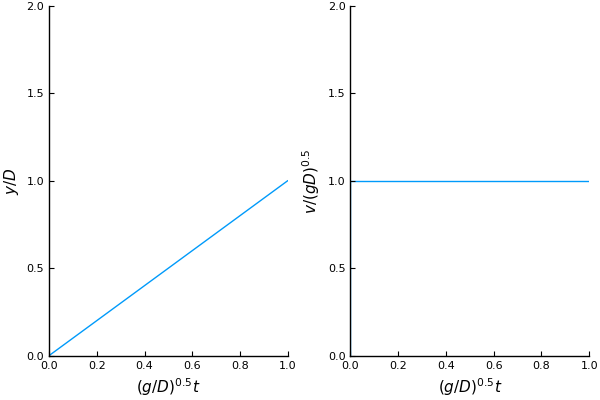

In [43]:
pp = plot([0.0;thist],phist,xlabel="\$(g/D)^{0.5}t \$",ylabel="\$y/D\$",legend=false,xlims=(0,1),ylims=(0,2))
pv = plot([0.0;thist],vhist,xlabel="\$(g/D)^{0.5}t \$",ylabel="\$v/(gD)^{0.5}\$",legend=false,xlims=(0,1),ylims=(0,2))

plot(pp,pv)

#### Lift and drag coefficients

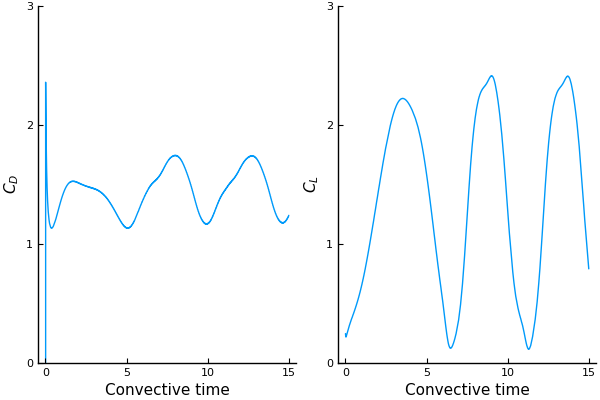

In [44]:
px = plot(thist,2*fx,ylim=(0,3),xlabel="Convective time",ylabel="\$C_D\$",legend=false)
py = plot(thist,2*fy,ylim=(0,3),xlabel="Convective time",ylabel="\$C_L\$",legend=false)
plot(px,py)

Cl = F/(0.5*ρU^2) = ρUΓ/(0.5*ρU^2)

In [48]:
circ = 0.0
for i in 1:length(xg), j in 1:length(yg)
    if (xg[i]-1)^2+(yg[j]-1)^2 >= 0.5^2
        circ += whist[end][i,j]
    end
end
(-circ*Δx^2)/(0.5*1)

0.11545368937794963

In [49]:
2.2*0.5

1.1

## <span style="color:blue"> Save Data </span>

#### Save all current data .bson file

In [45]:
@save filename*".bson" bd bdhist xg yg whist vshist thist fx fy Δt w qJ v t f

#### Use the following block to extract data

In [46]:
# using Dyn3d
# using ViscousFlow

# @load filename*".bson" bd bdhist xg yg whist vshist thist fx fy Δt w qJ v t f
# @get bd (bs,js,sys);